# Taxi

## Описание среды

![image.png](image.png)

В мире сетки 5x5 есть четыре обозначенных места посадки и высадки (красное, зеленое, желтое и синее). Такси начинает движение в случайном квадрате, а пассажир — в одном из обозначенных мест.

Цель - доставить такси к месту нахождения пассажира, забрать пассажира, доставить его в желаемое место назначения и высадить пассажира. После высадки пассажира эпизод заканчивается.

Игрок получает положительные награды за успешную высадку пассажира в правильном месте. Отрицательные награды за неправильные попытки подобрать/высадить пассажира и за каждый шаг, на котором не получено еще одно вознаграждение.


### Пространство действий

- 0: Двигаться на юг (вниз)
- 1: Двигайтесь на север (вверх)
- 2: Двигайтесь на восток (вправо)
- 3: Двигайтесь на запад (налево)
- 4: Посадить пассажира
- 5: Высадить пассажира

### Награды

- -1 за шаг, если не активируется другая награда.
- +20 за доставку пассажира.
- -10 незаконное выполнение действий по «посадке» и «высадке».

### Начальные состояния
Существует 300 возможных начальных состояний: 25 позиций такси * 4 местоположения пассажира (исключая внутри такси) * 3 пункта назначения (исключая текущее местоположение пассажира).

### Достижмые состояние
Существует 404 состояний, которые фактически могут быть достигнуты во время эпизода: 25 позиций такси * 4 пункта назначения * 4 состояния, когда начальное расположение пассажира не совпадает с пунктом назначения + 4 дополнительных состояния, когда такси и пассажир в пункте назначения вместе.

### Конец эпизода

- Окончание: Такси высаживает пассажира.
- Превышение длины эпизода (при использовании оболочки time_limit): Длина эпизода — 200.

## Как будем решать?

Напишем собственные реализации:
- Value Iteration - семейство алгоритмов Dynamic Programming
- SARSA, Q-learning - семейство алгоритмов Temporal Difference

In [13]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

from IPython import display
from tqdm import tqdm

%matplotlib inline

### Функции проигрования эпизода

In [14]:
def compute_policy(policy: np.ndarray) -> np.ndarray:
    """
    Computes the optimal policy based on the given policy matrix.

    Parameters
    ----------
    - policy (np.ndarray): A policy matrix of size (n_states, n_actions), where each element represents
    the probability of taking an action in a given state.

    Returns
    -------
    - np.ndarray: An optimal policy of size (n_states,), 
    where each element represents the index of the action to take in a given state.
    """
    return np.argmax(policy, axis=1)

def play_episode(env: gym.Env, policy: np.ndarray) -> tuple:
    """
    Plays a single episode in the environment using the given policy.

    Parameters
    ----------
    - env (gym.Env): The Gym environment in which the episode is played.
    - policy (np.ndarray): An optimal policy of size (n_states,), 
    where each element represents the index of the action to take in a given state.

    Returns
    -------
    - tuple: A tuple containing:
        - total_reward (float): The total reward accumulated during the episode.
        - frames (list): A list of frames representing the visual output of the environment at each step.
        - terminated (bool): A boolean indicating whether the episode was terminated.
    """
    env.reset()

    total_reward = 0
    frames = []

    for _ in range(1000):
        observation, reward, terminated, _ , _ = env.step(policy[env.env.s])
        total_reward += reward

        frames.append(env.render())

        if terminated:
            break
    
    return total_reward, frames, terminated

def evaluate_optimal_policy(env: gym.Env, policy: np.ndarray, max_iters: int = 10000) -> tuple:
    """
    Evaluates the optimal policy by playing multiple episodes and calculating the mean reward and win rate.

    Parameters
    ----------
    - env (gym.Env): The Gym environment in which the episodes are played.
    - policy (np.ndarray): An optimal policy of size (n_states,),
    where each element represents the index of the action to take in a given state.
    - max_iters (int): The maximum number of episodes to play. Default is 10000.

    Returns
    -------
    - tuple: A tuple containing:
        - mean_reward (float): The mean reward accumulated over all episodes.
        - win_rate (float): The win rate, calculated as the proportion of episodes that resulted in a win.
    """
    total_rewards = []
    total_wins = []

    for _ in tqdm(range(max_iters)):

        reward, _, win = play_episode(env, policy)

        total_rewards.append(reward)
        total_wins.append(win)

    mean_reward = sum(total_rewards)/len(total_rewards)
    win_rate = sum(total_wins)/len(total_wins)

    return (mean_reward, win_rate)

def vizualize_episode(frames: list) -> None:
    """
    Visualizes a single episode by displaying the frames sequentially.

    Parameters
    ----------
    - frames (list): A list of frames representing the visual output of the environment at each step.

    Returns
    -------
    - None
    """
    display.clear_output(wait=True)

    for frame in frames:
        plt.gca().clear()
        plt.axis('off')
        plt.imshow(frame)
        display.display(plt.gcf())
        display.clear_output(wait=True)



In [15]:
env = gym.make('Taxi-v3',render_mode='rgb_array')

### Value Iteration

In [16]:
def one_step_lookahead(env: gym.Env, state: int, V: np.ndarray, discount_factor: float) -> np.ndarray:
    """
    Computes the action-values for a given state by looking one step ahead.

    Parameters
    ----------
    - env (gym.Env): The Gym environment.
    - state (int): The current state.
    - V (np.ndarray): The value function of size (n_states,).
    - discount_factor (float): The discount factor for future rewards.

    Returns
    -------
    - np.ndarray: The action-values for the given state of size (n_actions,).
    """
    action_values = np.zeros(env.action_space.n)

    for action in range(env.action_space.n):
        for prob, next_state, reward, _ in env.P[state][action]:
            action_values[action] += prob * (reward + discount_factor * V[next_state])
    
    return action_values

def value_iteration(env: gym.Env, discount_factor: float = 1.0, theta: float = 1e-9, max_iters: int = 10000) -> tuple:
    """
    Performs value iteration to find the optimal policy and value function.

    Parameters
    ----------
    - env (gym.Env): The Gym environment.
    - discount_factor (float): The discount factor for future rewards. Default is 1.0.
    - theta (float): The threshold for convergence. Default is 1e-9.
    - max_iters (int): The maximum number of iterations. Default is 10000.

    Returns
    -------
    - tuple: A tuple containing:
        - policy (np.ndarray): The optimal policy of size (n_states, n_actions).
        - V (np.ndarray): The optimal value function of size (n_states,).
    """
    V = np.zeros(env.observation_space.n)

    for iter in range(max_iters):
        delta = 0

        for state in range(env.observation_space.n):
            action_values = one_step_lookahead(env, state, V, discount_factor)
            best_action_value = np.max(action_values)

            delta = max(delta,np.abs(V[state] - best_action_value))

            V[state] = best_action_value

        print(delta)
        if delta < theta:
            print(f'Value-iteration converged at iteration#{iter}.')
            break

    policy = np.zeros([env.observation_space.n, env.action_space.n])
    for state in range(env.observation_space.n):
        action_values = one_step_lookahead(env, state, V, discount_factor)
        best_action = np.argmax(action_values)

        policy[state, best_action] = 1.0

    return (policy, V)

In [17]:
policy, V = value_iteration(env=env, max_iters=1000, discount_factor=0.8)

19.2
15.36
12.288
9.830400000000001
7.864320000000001
6.291456000000001
5.0331648000000015
4.026531840000001
3.2212254720000013
2.061584302080001
1.3194139533312024
0.8444249301319684
0.5404319552844608
0.3458764513820545
0.22136092888451486
0.14167099448608944
0.09066943647109849
0.058028439341502924
0.03713820117856237
0.02376844875427997
0.01521180720273918
0.009735556609753004
0.006230756230242385
0.003987683987355162
0.0025521177519074456
0.0016333553612208895
0.0010453474311820088
0.0006690223559573383
0.0004281743078123901
0.0002740315570000096
0.00017538019648011272
0.00011224332574855111
7.183572847857533e-05
4.5974866226594635e-05
2.9423914386761396e-05
1.8831305205857518e-05
1.2052035333276478e-05
7.71330261262193e-06
4.9365136726153835e-06
3.159368750615954e-06
2.021995999967885e-06
1.2940774425374002e-06
8.282095618206142e-07
5.300541214836585e-07
3.392346372699251e-07
2.1711016817693718e-07
1.3895050887668958e-07
8.892832481510737e-08
5.6914128299112576e-08
3.642504431411

In [18]:
policy = compute_policy(policy)
mean_reward, win_rate = evaluate_optimal_policy(env, policy, max_iters=100)

print(f'Средняя награда равна {mean_reward}')
print(f'Доля побед среди всех игр равна {win_rate}')

100%|██████████| 100/100 [00:09<00:00, 10.56it/s]

Средняя награда равна 8.2
Доля побед среди всех игр равна 1.0


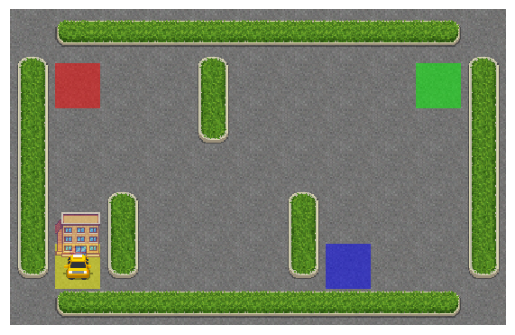

In [19]:
_ , frames, _ = play_episode(env,policy)

vizualize_episode(frames)

### SARSA

In [21]:
def SARSA_learning_episode(env: gym.Env, policy: np.ndarray, Q: np.ndarray, alpha: float = 0.05,
                            gamma: float = 1.0, epsilon: float = 0.0, steps: int = 1000) -> None:
    """
    Performs a single episode of SARSA learning to update the Q-values and policy.

    Parameters
    ----------
    - env (gym.Env): The Gym environment.
    - policy (np.ndarray): The current policy, where each key is a state and each value is the corresponding action.
    - Q (np.ndarray): The Q-values matrix of size (n_states, n_actions).
    - alpha (float): The learning rate. Default is 0.05.
    - gamma (float): The discount factor for future rewards. Default is 1.0.
    - epsilon (float): The exploration rate. Default is 0.0 (no exploration).
    - steps (int): The maximum number of steps per episode. Default is 1000.

    Returns
    -------
    - None
    """
    env.reset()
    s, a = env.env.s, policy[env.env.s] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)

    for _ in range(steps):
        observation, reward, terminated, _ , _ = env.step(a)
        s_prime, a_prime = env.env.s, policy[env.env.s] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
        Q[s, a] = Q[s, a] + alpha * (reward + gamma * Q[s_prime, a_prime] - Q[s, a])
        s, a = s_prime, a_prime

        if terminated:
            break

def get_random_Q(env: gym.Env) -> np.ndarray:
    """
    Generates a random Q-values matrix for the given environment.

    Parameters
    ----------
    - env (gym.Env): The Gym environment.

    Returns
    -------
    - np.ndarray: A random Q-values matrix of size (n_states, n_actions), where Q-values for final states are set to 0.0.
    """
    Q = np.random.random(size=(env.observation_space.n, env.action_space.n))
    final_states = np.where([len(env.env.P[x][0]) == 1 and env.env.P[x][0][0][3] == True for x in env.env.P.keys()])[0]
    Q[final_states, :] = 0.0
    return Q

def compute_policy_by_Q(Q: np.ndarray) -> np.ndarray:
    """
    Computes the policy based on the given Q-values matrix.

    Parameters
    ----------
    - Q (np.ndarray): The Q-values matrix of size (n_states, n_actions).

    Returns
    -------
    - np.ndarray: The policy of size (n_states,), where each element represents the index of the action to take in a given state.
    """
    return np.argmax(Q, axis=1)

In [22]:
Q = get_random_Q(env)
policy = compute_policy_by_Q(Q)
epsilon = 0.05

for iter in tqdm(range(1000)):
    SARSA_learning_episode(env=env, policy=policy, Q=Q, epsilon=epsilon)
    policy = compute_policy_by_Q(Q)

c:\Users\Vasily\anaconda3\envs\Bayes\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\Vasily\anaconda3\envs\Bayes\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 1000/1000 [00:33<00:00, 30.11it/s]


In [12]:
mean_reward, win_rate = evaluate_optimal_policy(env, policy, max_iters=100)

print(f'Средняя награда равна {mean_reward}')
print(f'Доля побед среди всех игр равна {win_rate}')

100%|██████████| 100/100 [04:39<00:00,  2.79s/it]

Средняя награда равна -805.35
Доля побед среди всех игр равна 0.55


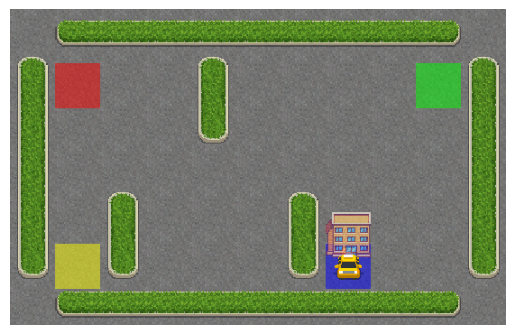

In [26]:
env.reset()

_ , frames, _ = play_episode(env,policy)

vizualize_episode(frames)

### Q-learning

In [28]:
def Q_learning_episode(env: gym.Env, policy: np.ndarray, Q: np.ndarray, alpha: float = 0.05,
                            gamma: float = 1.0, epsilon: float = 0.0, steps: int = 1000) -> None:
    """
    Performs a single episode of Q-learning to update the Q-values and policy.

    Parameters
    ----------
    - env (gym.Env): The Gym environment.
    - policy (np.ndarray): The current policy, where each key is a state and each value is the corresponding action.
    - Q (np.ndarray): The Q-values matrix of size (n_states, n_actions).
    - alpha (float): The learning rate. Default is 0.05.
    - gamma (float): The discount factor for future rewards. Default is 1.0.
    - epsilon (float): The exploration rate. Default is 0.0 (no exploration).
    - steps (int): The maximum number of steps per episode. Default is 1000.

    Returns
    -------
    - None
    """
    env.reset()
    s, a = env.env.s, policy[env.env.s] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)

    for _ in range(steps):
        observation, reward, terminated, _ , _ = env.step(a)
        s_prime, a_prime = env.env(s), policy[env.env.s] if np.random.rand() > epsilon else np.random.randint(env.action_space.n)
        Q[s, a] = Q[s, a] + alpha * (reward + gamma * np.max(Q[s_prime]) - Q[s, a])
        s, a = s_prime, a_prime

        if terminated:
            break

In [29]:
Q = get_random_Q(env)
policy = compute_policy_by_Q(Q)
epsilon = 0.05

for iter in tqdm(range(1000)):
    SARSA_learning_episode(env=env, policy=policy, Q=Q, epsilon=epsilon, gamma=0.9, alpha=0.05)
    policy = compute_policy_by_Q(Q)

c:\Users\Vasily\anaconda3\envs\Bayes\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Vasily\anaconda3\envs\Bayes\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 1000/1000 [00:37<00:00, 26.44it/s]


In [30]:
mean_reward, win_rate = evaluate_optimal_policy(env, policy, max_iters=100)

print(f'Средняя награда равна {mean_reward}')
print(f'Доля побед среди всех игр равна {win_rate}')

100%|██████████| 100/100 [07:43<00:00,  4.64s/it]

Средняя награда равна -788.29
Доля побед среди всех игр равна 0.21


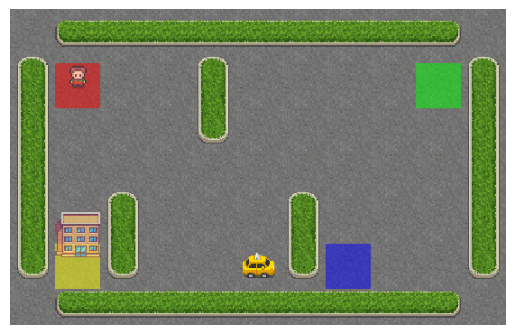

In [35]:
env.reset()

_ , frames, _ = play_episode(env,policy)

vizualize_episode(frames)

## Вывод
Лучше всех показал себя алгоритм Value Iteration.